Intro:


Training samples: 10175
Classes: ['Basophil', 'Eosinophil', 'Lymphocyte', 'Monocyte', 'Neutrophil']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


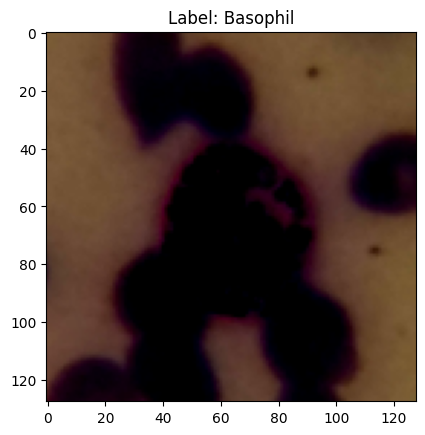

In [1]:
# Data
import numpy as np
import math
from torchvision import datasets, transforms
from torch.utils.data import DataLoader


transform = transforms.Compose([
    transforms.Resize((128, 128)),  #resize all images to 128x128
    transforms.ToTensor(),         #converts images to PyTorch tensors
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])


train_dataset = datasets.ImageFolder(root='dataset/Train', transform=transform)
testA_dataset = datasets.ImageFolder(root='dataset/TestA', transform=transform)
testB_dataset = datasets.ImageFolder(root='dataset/Test-B', transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
testA_loader = DataLoader(testA_dataset, batch_size=32, shuffle=False)
testB_loader = DataLoader(testB_dataset, batch_size=32, shuffle=False)


# TEST AND VISUALIZE DATASET BELOW ------------------------------------------------
print(f"Training samples: {len(train_dataset)}")
print(f"Classes: {train_dataset.classes}")

import matplotlib.pyplot as plt
image, label = train_dataset[0]  #this shows the first image under the train dataset (first image under basophil)
plt.imshow(image.permute(1, 2, 0))  #convert (C, H, W) to (H, W, C) so matplotlib can recognize image.
plt.title(f"Label: {train_dataset.classes[label]}")
plt.show() # Note!!! The image is normalized, so it looks pretty dark when plt.show().


In [ ]:
# Decision Tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.decomposition import PCA

In [ ]:
#this function gets features and labels from dataset. It flattens each image from (C,H,W) into a 1D array.
def get_features_labels(dataset):
    features = []
    labels =[]
    for image, label in dataset:
        features.append(image.view(-1).numpy())
        labels.append(label)
    return np.array(features), np.array(labels)

X, y = get_features_labels(train_dataset)
print("Original feature shape:", X.shape)

#split data into training and test sets (80%-20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
#here I train the train dataset on the Decision Tree classifier:
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)

#predict on the test set:
y_pred = dt.predict(X_test)


#evaluate accuracy on the test set:
accuracy = accuracy_score(y_test, y_pred)



print("Decision Tree test accuracy: {:.2f}%".format(accuracy*100))
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=train_dataset.classes))

Original feature shape: (10175, 49152)
Decision Tree Test Accuracy: 78.62%

Classification Report:
               precision    recall  f1-score   support

    Basophil       0.53      0.70      0.60        43
  Eosinophil       0.40      0.38      0.39       167
  Lymphocyte       0.82      0.83      0.83       489
    Monocyte       0.42      0.46      0.44       115
  Neutrophil       0.88      0.86      0.87      1221

    accuracy                           0.79      2035
   macro avg       0.61      0.65      0.62      2035
weighted avg       0.79      0.79      0.79      2035



In [5]:
# CNN


In [6]:
# Vision Transformer
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms

# Image size for ViT/ResNet
IMG_SIZE = 224

train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])  # For grayscale images adjust if needed
])

train_dataset = datasets.ImageFolder('path_to_train_folder', transform=train_transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)

FileNotFoundError: [Errno 2] No such file or directory: 'path_to_train_folder'

Conclusion:
